# Supervised Machine Learning Solution

In [11]:
# import the necessary libraries

import os 
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [12]:
# import sklearn models

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, roc_auc_score, plot_confusion_matrix,
                             precision_recall_curve, roc_curve)

In [13]:
# import imblearn to deal with unbalanced classes
from imblearn.ensemble import BalancedBaggingClassifier

In [14]:
warnings.filterwarnings("ignore")

## Import the Dataset

In [15]:
data = pd.read_csv('new_physics_signal.csv')

In [16]:
# print first 5 rows to have a brief look on the dataset
data.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,Class
0,78.482022,52.871985,-64.917465,-78.448475,-57.987246,-92.520585,27.806597,46.774201,-57.512910,22.899098,-38.790567,-83.959697,11.666977,846.710033,0
1,78.379086,55.058180,-68.153619,-82.693368,-59.561586,-93.335494,19.354007,47.128549,-60.470478,23.100267,-36.209469,-84.888323,11.836796,25.025335,0
2,79.609922,55.395154,-61.506139,-99.031856,-56.643424,-91.474574,32.361097,48.480810,-63.011139,20.523559,-38.380731,-85.190411,11.483291,2127.582986,0
3,80.592326,55.085738,-73.077999,-91.084996,-60.244160,-92.874068,25.292852,46.640591,-66.546879,25.600912,-39.059436,-84.421174,12.058619,700.637724,0
4,75.686606,56.323331,-69.943208,-75.363929,-57.215389,-92.485721,32.606410,46.729047,-56.972408,21.156952,-33.125372,-83.400313,12.788145,401.390816,0


## Data Preprocessing

In [17]:
# check null values
data.isnull().sum()

p1       5
p2       5
p3       5
p4       5
p5       5
p6       5
p7       5
p8       5
p9       5
p10      5
p11      5
p12      5
p13      5
p14      5
Class    0
dtype: int64

In [18]:
# remove the values containing null
data = data.dropna()
data.isnull().sum()

p1       0
p2       0
p3       0
p4       0
p5       0
p6       0
p7       0
p8       0
p9       0
p10      0
p11      0
p12      0
p13      0
p14      0
Class    0
dtype: int64

In [19]:
# count classes present in the dataset
data['Class'].value_counts()

0    284245
1       492
Name: Class, dtype: int64

In [20]:
"""
As we can see that there are 492 datapoints with class value 1 and other 284245 is 0, which is unbalanced
and makes the model a bit overfitted and biased for class 0

Balancing the unbalanced data by randomly sampling the class with more datapoints. We took 600 random sampled 
datapoints from class 0 and keeping all the 423 number of datapoints for class 1. So that it is kept balanced. 
(however, I did't use the same technique for the previous notebook, in order to see the model performance)

This step is to deal with the bias-variance trade-off.
"""
shuffled = data.sample(frac=1, random_state=4)
data_zero = shuffled.loc[shuffled['Class'] == 0].sample(n=600, random_state = 123)
data_one = shuffled.loc[shuffled['Class'] == 1]

data_sampled_concated = pd.concat([data_zero, data_one]).sample(frac=1, random_state=4)
data_sampled_concated = data_sampled_concated.reset_index(drop=True)
data = data_sampled_concated

In [21]:
"""
x = Taking all the rows and columns (not the last)
y = Taking all the rows but just the last column
"""

data_x = data.iloc[:, :-1]
data_y = data.iloc[:, -1:]

## Scaling and splitting the dataset into the training set and test set

In [34]:
# Standardizing the data between the value of -1 to + 1
scaler = StandardScaler()

In [35]:
data_x_scaled = scaler.fit_transform(data_x)

In [26]:
# Converting pandas dataframe into numpy arrays
X = np.array(data_x_scaled)
y = np.array(data_y)

In [27]:
# Splitting the training to validation by a ratio of 70 to 30 %
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1234)

In [28]:
"""
From those 30 % spliiting further to 90 % validation and 10 % test, so all over
70 % train, 20 % validation and 10 % test
"""
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.1)

In [29]:
print(f"X_train : {X_train.shape}, X_valid : {X_valid.shape}, X_test : {X_test.shape}")
print(f"X_train : {y_train.shape}, y_valid : {y_valid.shape}, y_test : {y_test.shape}")

X_train : (764, 14), X_valid : (295, 14), X_test : (33, 14)
X_train : (764, 1), y_valid : (295, 1), y_test : (33, 1)


## Running the model experiments

In [30]:
"""
run_model function
    -> First it trains the model
    -> predicts for validation set and test set
    -> calculates the accuracy, precision, recall for both validation and test set
    -> plots the confusion matrix for validation and test set
    -> returns those values of acc, precision, recall for validation and test set
"""

def run_model(model):
    model.fit(X_train, y_train)
    y_valid_predicted = model.predict(X_valid)
    y_test_predicted = model.predict(X_test)
    
    valid_acc = accuracy_score(y_valid, y_valid_predicted)
    valid_precision = precision_score(y_valid, y_valid_predicted)
    valid_recall = recall_score(y_valid, y_valid_predicted)
    
    test_acc = accuracy_score(y_test, y_test_predicted)
    test_precision = precision_score(y_test, y_test_predicted)
    test_recall = recall_score(y_test, y_test_predicted)
    
    print(f"Validation ACC: {valid_acc:.3f}, Precision: {valid_precision:.3f}, Recall: {valid_recall:.3f}")
    print(f"Testing ACC: {test_acc:.3f}, Precision: {test_precision:.3f}, Recall: {test_recall:.3f}")
    
    plot_confusion_matrix(model, X_valid, y_valid, cmap="GnBu")
    plt.title('Validation Confusion matrix plot')
    plt.show()
    
    plot_confusion_matrix(model, X_test, y_test, cmap="GnBu")
    plt.title('Testing Confusion matrix plot')
    plt.show()
    
    return (valid_acc, valid_precision, valid_recall), (test_acc, test_precision, test_recall)

In [31]:
"""
We run 5 differnt ML classifiers viz:
    'RANDOM FOREST CLASSIFIER',
    'DECISION TREE CLASSIFIER',
    'KNN',
    'LOGISTIC REGRESSION',
    'SVM',
    'BALANCED BAGGIN CLASSIFIER (DECISION TREE as BASE)',
    'BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)'

where ('BALANCED BAGGIN CLASSIFIER (DECISION TREE as BASE)','BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)') 
are ensemble model method which takes care of inbalanced data
    
run_all_model function
    -> Runs the run_model() function for all the classifiers one by one
    -> logs the returned values in a dictionary

"""

def run_all_models(models, model_names):
    all_valid_acc = {}
    all_valid_precision = {}
    all_valid_recall = {}
    
    all_test_acc = {}
    all_test_precision = {}
    all_test_recall = {}
    
    for model, model_name in tqdm(zip(models, model_names), total=len(models)):
        print(f"\nUSING {model_name}")
        (valid_acc, valid_precision, valid_recall), (test_acc, test_precision, test_recall) = run_model(model)
        
        all_valid_acc[model_name] = valid_acc
        all_valid_recall[model_name] = valid_recall
        all_valid_precision[model_name] = valid_precision
        
        all_test_acc[model_name] = test_acc
        all_test_recall[model_name] = test_recall
        all_test_precision[model_name] = test_precision
    
    return {
        'all_valid_acc' : all_valid_acc,
        'all_valid_recall' : all_valid_recall,
        'all_valid_precision' : all_valid_precision,
        
        'all_test_acc' : all_test_acc,
        'all_test_recall' : all_test_recall,
        'all_test_precision' : all_test_precision
    }

## Running all the models

  0%|          | 0/7 [00:00<?, ?it/s]


USING RANDOM FOREST CLASSIFIER
Validation ACC: 0.912, Precision: 0.922, Recall: 0.881
Testing ACC: 0.909, Precision: 0.929, Recall: 0.867


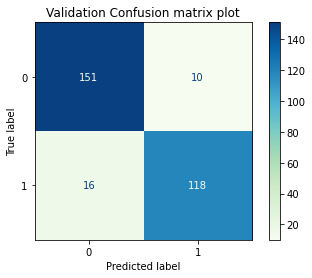

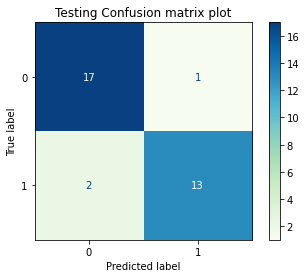


USING DECISION TREE CLASSIFIER
Validation ACC: 0.780, Precision: 0.776, Recall: 0.724
Testing ACC: 0.818, Precision: 0.800, Recall: 0.800


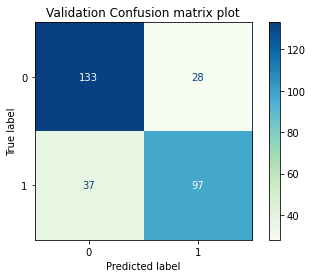

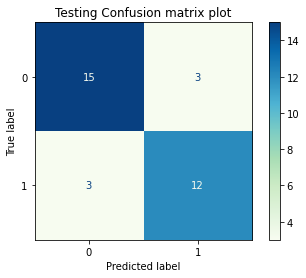


USING KNN
Validation ACC: 0.776, Precision: 0.847, Recall: 0.619
Testing ACC: 0.848, Precision: 0.917, Recall: 0.733


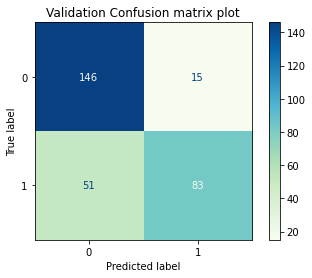

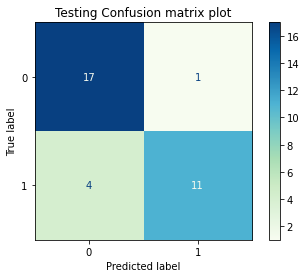


USING LOGISTIC REGRESSION
Validation ACC: 0.692, Precision: 0.697, Recall: 0.567
Testing ACC: 0.788, Precision: 0.750, Recall: 0.800


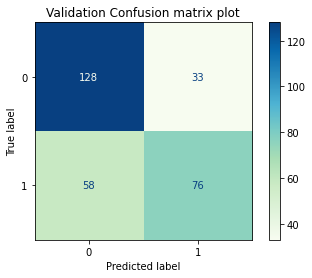

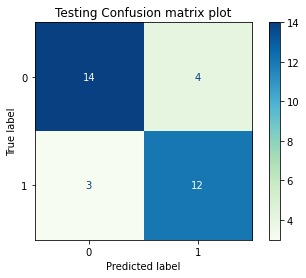


USING SVM
Validation ACC: 0.871, Precision: 0.929, Recall: 0.776
Testing ACC: 0.909, Precision: 1.000, Recall: 0.800


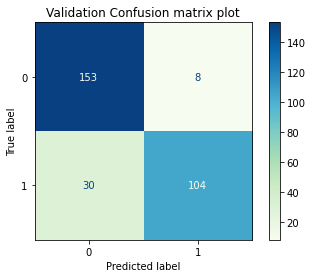

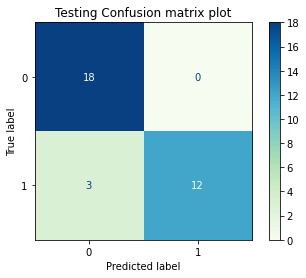


USING BALANCED BAGGIN CLASSIFIER (DECISION TREE as BASE)
Validation ACC: 0.881, Precision: 0.909, Recall: 0.821
Testing ACC: 0.879, Precision: 0.923, Recall: 0.800


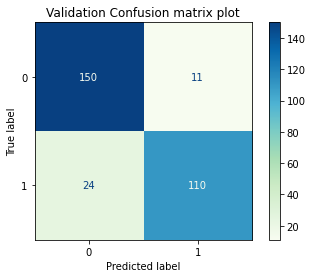

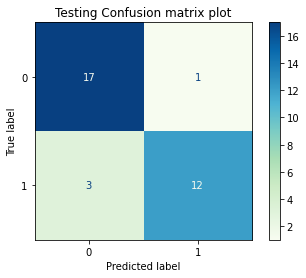


USING BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)
Validation ACC: 0.888, Precision: 0.874, Recall: 0.881
Testing ACC: 0.909, Precision: 0.929, Recall: 0.867


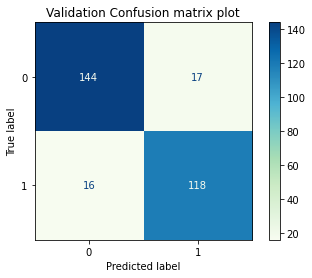

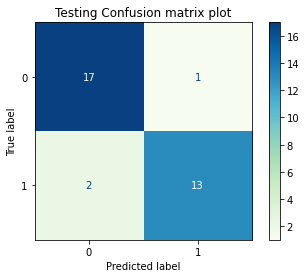

In [32]:
"""
For each model we can see the validation and test acc, precision and recall
and also we can see the confusion matrix for validation and test set.

"""

MODELS = [
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=3),
    LogisticRegression(random_state=0),
    svm.SVC(),
    BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                              sampling_strategy='auto',
                              replacement=False, 
                              random_state=0),
    
    BalancedBaggingClassifier(base_estimator=RandomForestClassifier(),
                             sampling_strategy='auto',
                             replacement=False, 
                             random_state=0)
]

MODEL_NAMES = [
    'RANDOM FOREST CLASSIFIER',
    'DECISION TREE CLASSIFIER',
    'KNN',
    'LOGISTIC REGRESSION',
    'SVM',
    'BALANCED BAGGIN CLASSIFIER (DECISION TREE as BASE)',
    'BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)'
    
]

MODEL_LOGS = run_all_models(MODELS, MODEL_NAMES)

In [33]:
import json
print(json.dumps(MODEL_LOGS, sort_keys=False, indent=4))

{
    "all_valid_acc": {
        "RANDOM FOREST CLASSIFIER": 0.911864406779661,
        "DECISION TREE CLASSIFIER": 0.7796610169491526,
        "KNN": 0.7762711864406779,
        "LOGISTIC REGRESSION": 0.6915254237288135,
        "SVM": 0.8711864406779661,
        "BALANCED BAGGIN CLASSIFIER (DECISION TREE as BASE)": 0.8813559322033898,
        "BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)": 0.888135593220339
    },
    "all_valid_recall": {
        "RANDOM FOREST CLASSIFIER": 0.8805970149253731,
        "DECISION TREE CLASSIFIER": 0.7238805970149254,
        "KNN": 0.6194029850746269,
        "LOGISTIC REGRESSION": 0.5671641791044776,
        "SVM": 0.7761194029850746,
        "BALANCED BAGGIN CLASSIFIER (DECISION TREE as BASE)": 0.8208955223880597,
        "BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)": 0.8805970149253731
    },
    "all_valid_precision": {
        "RANDOM FOREST CLASSIFIER": 0.921875,
        "DECISION TREE CLASSIFIER": 0.776,
        "KNN": 0.8469387755

We can see from the `MODEL_LOGS` that `BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)` is the best model and 
most generalized as it has the following metric:

1. Validation Accuracy  : 88.8 %
2. Validation Precision : 86.8 %
3. Validation Recall    : 87.5 %

4. Test Accuracy  : 90.9 %
5. Test Precision : 95 %
6. Test Recall    : 90.4 %

So `BALANCED BAGGIN CLASSIFIER (RANDOM FOREST as BASE)` is the best among all as an ensemble technique.